# Salary Predictions Based on Job Descriptions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, './scripts')
from helpers import load_data, mean_squared_error
from NaiveModel import NaiveModel

### Obtaining the Data

In [3]:
#load the data into a Pandas dataframe
path = './raw_data/'
files = ['train_features.csv', 'train_salaries.csv']

train_features = load_data(path, files[0], verbose=True)

------------------------------train_features shape------------------------------
                                  (1000000, 7)                                  
-------------------------train_features's column types--------------------------
companyId              object
jobType                object
degree                 object
major                  object
industry               object
yearsExperience         int64
milesFromMetropolis     int64
dtype: object
-------------------------train_features first five rows-------------------------
                 companyId         jobType       degree      major industry  \
jobId                                                                         
JOB1362684407687    COMP37             CFO      MASTERS       MATH   HEALTH   
JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE      WEB   
JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   HEALTH   
JOB1362684407690    COMP38         MANAGER     DOCTORAL  

In [4]:
train_salaries = load_data(path, files[1], verbose=True)

------------------------------train_salaries shape------------------------------
                                  (1000000, 1)                                  
-------------------------train_salaries's column types--------------------------
salary    int64
dtype: object
-------------------------train_salaries first five rows-------------------------
                  salary
jobId                   
JOB1362684407687     130
JOB1362684407688     101
JOB1362684407689     137
JOB1362684407690     142
JOB1362684407691     163


The features and target variable have the same number of rows which is a good sign that there won't be missing data.

In [5]:
train_merged = train_salaries.merge(train_features, right_on = 'jobId', left_on = 'jobId')
train_merged.shape

(1000000, 8)

The shape is retained during the merge, so there was a salary for every job posting.

In [6]:
train_merged.head()

,salary,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
jobId,,,,,,,,
JOB1362684407687,130,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
JOB1362684407688,101,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
JOB1362684407689,137,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
JOB1362684407690,142,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
JOB1362684407691,163,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


### Cleaning the Data

In [7]:
# Ensuring the primary key is unique 
assert(train_merged.index.duplicated().sum() == 0)

All of the *jobId*s are in fact unique, so we can treat each row as a completely separate instance. If there were repeats, then I would further investigate the repeated ids to see if they all the information stayed consistent between the multiple postings and proceeded from there. 

In [8]:
train_merged.isnull().sum()

salary                 0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

There are no missing values in the data set as is. For the continuous variables *yearsExperience* and *milesFromMetropolis* I would have replaced the null values with the mean or median of the respective data depending on the actual distribution. For the categorical columns, I would have most likely had to remove the rows or columns containing null values a long as it was not a significant amount of loss.

I will note that there is a common value of *NONE* in the *major* column. This is not meant to specify the python "None" object. Rather, it is specifying that there is do specific major requirement for that job posting.

### Exploring the Data

Text(0.5, 1.0, 'Histogram of Salaries')

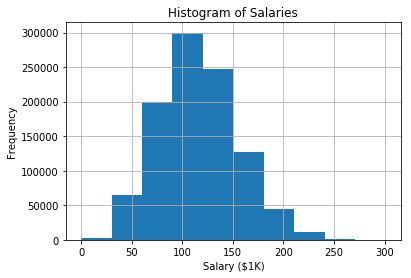

In [9]:
fig, ax = plt.subplots(1)
train_merged.salary.hist(ax=ax)
ax.set_xlabel('Salary ($1K)')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Salaries')

The distribution of salaries is fairly normal with a slight right skew which is to be expected when there is a lower bound and no upper bound. 

In [10]:
categorical_cols = [x for x in train_merged.columns if train_merged[x].dtype == object]
print(categorical_cols)

['companyId', 'jobType', 'degree', 'major', 'industry']


In [11]:
train_merged[categorical_cols].nunique()

companyId    63
jobType       8
degree        5
major         9
industry      7
dtype: int64

None of the columns seem to have a very high cardinality. The most unique values by far is *companyId* which has only 0.063% of the data as unique. This would give each company about 15000 data points on average. Even if it has a higher cardinality than the rest, the information could still give useful insights into competitor strategies. I will do the next basic exploration excluding *companyId*, but it will still be used in the final model.

In [12]:
categorical_cols.remove('companyId')

Average salary broken up by each categorical variable


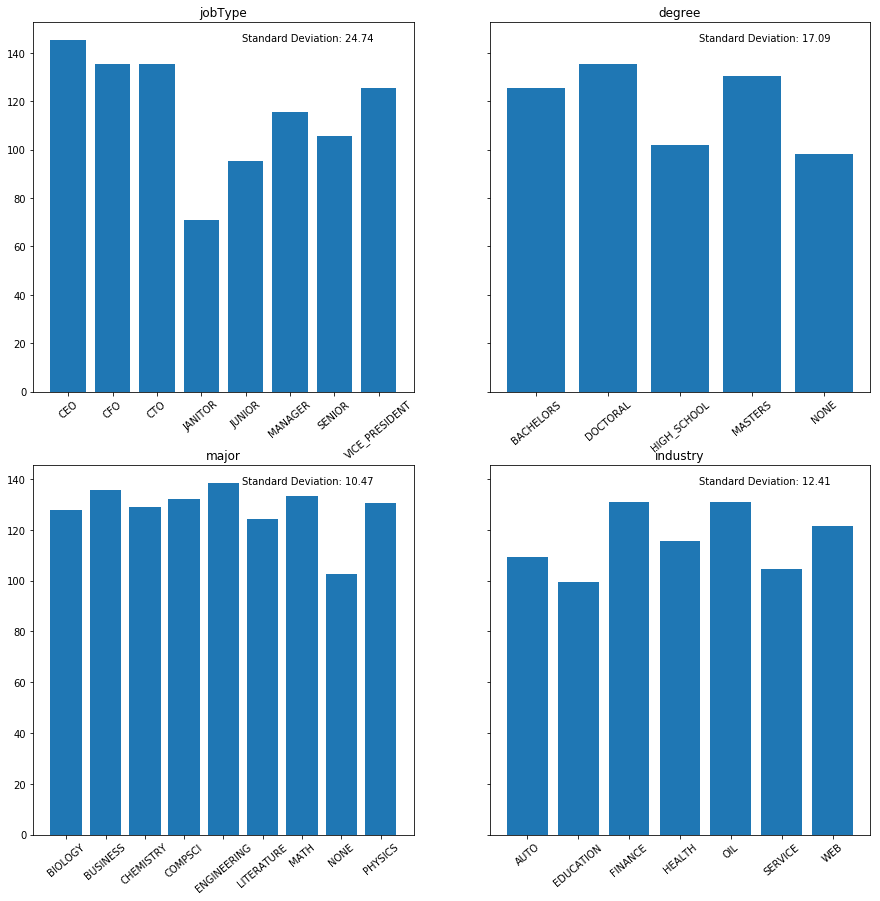

In [40]:
print('Average salary broken up by each categorical variable')

n = len(categorical_cols)
fig, ax = plt.subplots(round(n/2), 2, figsize=(15, 12), sharey='row')

row = 0
col = 0
count = 0

for row in range(round(n/2)):
    for col in range(2):
        mean = train_merged.groupby(categorical_cols[count])['salary'].mean()
        plt.sca(ax[row][col])
        plt.bar(height=mean, x=mean.index)
        plt.text(s=f'Standard Deviation: {mean.std():.2f}', x=.55, y=.95, transform=ax[row][col].transAxes)
        plt.xticks(rotation=40)
        plt.subplots_adjust(bottom=.05, top=.99)
        plt.title(categorical_cols[count])
        count += 1

The features *industry* and *major* average salaries don't vary nearly as much as *jobType* and *degree* average salary. We might not be able to learn as much information from them, and I'll keep it in mind when seeing if I want to do feature engineering.

In [14]:
numeric_cols = [x for x in train_merged.columns if x not in categorical_cols]
print(numeric_cols)

['salary', 'companyId', 'yearsExperience', 'milesFromMetropolis']


Text(0.5, 1.0, 'Numerical Values Correlation Heatmap')

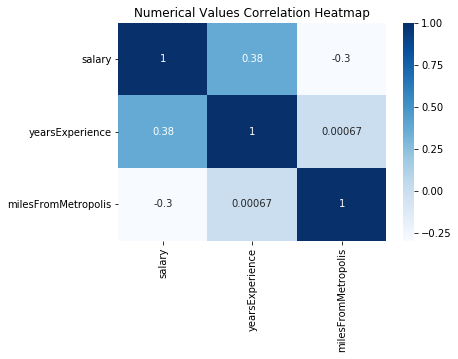

In [15]:
import seaborn as sns
ax = sns.heatmap(train_merged[numeric_cols].corr(), annot=True, cmap='Blues')
ax.set_title('Numerical Values Correlation Heatmap')

There is a somewhat significant positive correlation between *yearsExperience* and *salary*, and a just as strong negative correlation between *milesFromMetropolis* and *salary*. As the years of experience necessary for the job increases, the salary for the position increases. As the job moves farther away from a city, the salary for the position decreases. Both of these results are rather intuitive.

### Establishing a Baseline Outcome

I'm going to make a rather naive model using the average income of the job type as the only predictor. With the quick glance at the data I've done above, it seems that job type is the best individual predictor. I would like to show that my final model is better than just the naive approach.

I'll partition off a chunk of my data to act as the test data since none was originally given. This is so that I can train both the naive and final model on the same data.

In [16]:
from sklearn.model_selection import train_test_split
train_data_merged, test_data_merged = train_test_split(train_merged, test_size=.3, random_state=44)

I want to save these datasets externally so that I will be using the same training and test data between various notebooks

In [17]:
%%bash
rm -r ./model_validation_data

mkdir ./model_validation_data

In [18]:
train_data_merged.to_csv('./model_validation_data/train.csv')
test_data_merged.to_csv('./model_validation_data/test.csv')

In [17]:
# Creating a naive model on the training data I have

nm = NaiveModel(agg_col='jobType', target_col='salary')

# Fitting the model on the train data
nm.fit(train_data_merged)

# Predicting on test data
y_pred = nm.predict(test_data_merged)
y_actual = test_data_merged['salary']

print(mean_squared_error(y_pred, y_actual))

967.0928376323602


Great! Now we have a baseline to actually see how well our model actually is at predicting. I do want to quickly check how much better this naive model is than using the mean of the entire dataset instead of taking the mean split by a grouping.

In [18]:
print(mean_squared_error(train_data_merged['salary'].mean(), y_actual))

1506.2839629080158


Ok, the naive model was much better than just trying the mean of the test data.

### Hypothesizing Solutions


Given the comparison of the Naive Model to the prediction just using the training data mean as well as the variations we saw in the grouped means we know that the categorical values will definitely be useful in creating our model. The heatmap also showed that there was a correlation between the numerical values and the salary. More importantly, the heatmap also illustrated that *yearsExperience* and *milesFromMetropolis* had no correlation whatsoever, so we'll be able to learn information from both features independently. The only feature that looks close to useless is *major*, but the slight variation and increased dip in *NONE* as a value might help us get moree information.